In [2]:
import config
import functions
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [143]:
from jupyterthemes import jtplot

jtplot.style(theme='gruvboxd')

In [4]:
logreg = LogisticRegression(C=1, penalty='l1',
fit_intercept=True, max_iter=700, random_state=42, # l1_ratio=0.8,
                    solver='saga', n_jobs=-1, verbose=0)

In [5]:
X, y = functions.load_taxonomy(boolean=True)

In [6]:
def get_gmhi_values(logreg, X, y):
    logreg.fit(X, y)
    theta = pd.DataFrame(logreg.coef_[0], columns=['coef'], index=X.columns)
    gmhi_values = X @ theta
    gmhi_values.columns = ['gmhi_value']
    return gmhi_values.sort_values('gmhi_value')

In [7]:
gmhi_values = get_gmhi_values(logreg, X, y)
gmhi_values

gmhi_value
Study Accession Sample Accession or Sample ID            
PRJEB15371      SAMEA4431901                   -10.454713
PRJEB21528      SAMEA104142301                  -9.266116
                SAMEA104142237                  -9.124529
                SAMEA104142095                  -8.772720
N7              SAMN08813993                    -8.062552
...                                                   ...
PRJEB11532      SAMEA3665166                     5.863478
                SAMEA3664581                     6.220011
                SAMEA3664661                     6.449015
                SAMEA3664637                     6.806715
                SAMEA3664545                     9.744098

[5026 rows x 1 columns]

In [8]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import braycurtis

In [50]:
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 
           'braycurtis', 'canberra', #'chebyshev', 
           'correlation', 'dice', 
           'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 
           'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 
           'sokalmichener', 
           'sokalsneath', 'sqeuclidean', 'yule'] 

In [82]:
def plot_top_values(X, y, gmhi_values, num_top, metric):
    mds = MDS(n_components=2, random_state=42, n_jobs=-1, verbose=-1, dissimilarity='precomputed')
    top_X = X.loc[gmhi_values.iloc[:num_top, :].index | gmhi_values.iloc[-num_top:, :].index]
    distances = pairwise_distances(top_X, metric=metric)
    transformed = pd.DataFrame(mds.fit_transform(distances))
    transformed.index = top_X.index
    transformed.columns = ['MDS1', 'MDS2']
    transformed['isHealthy'] = y
    return transformed

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

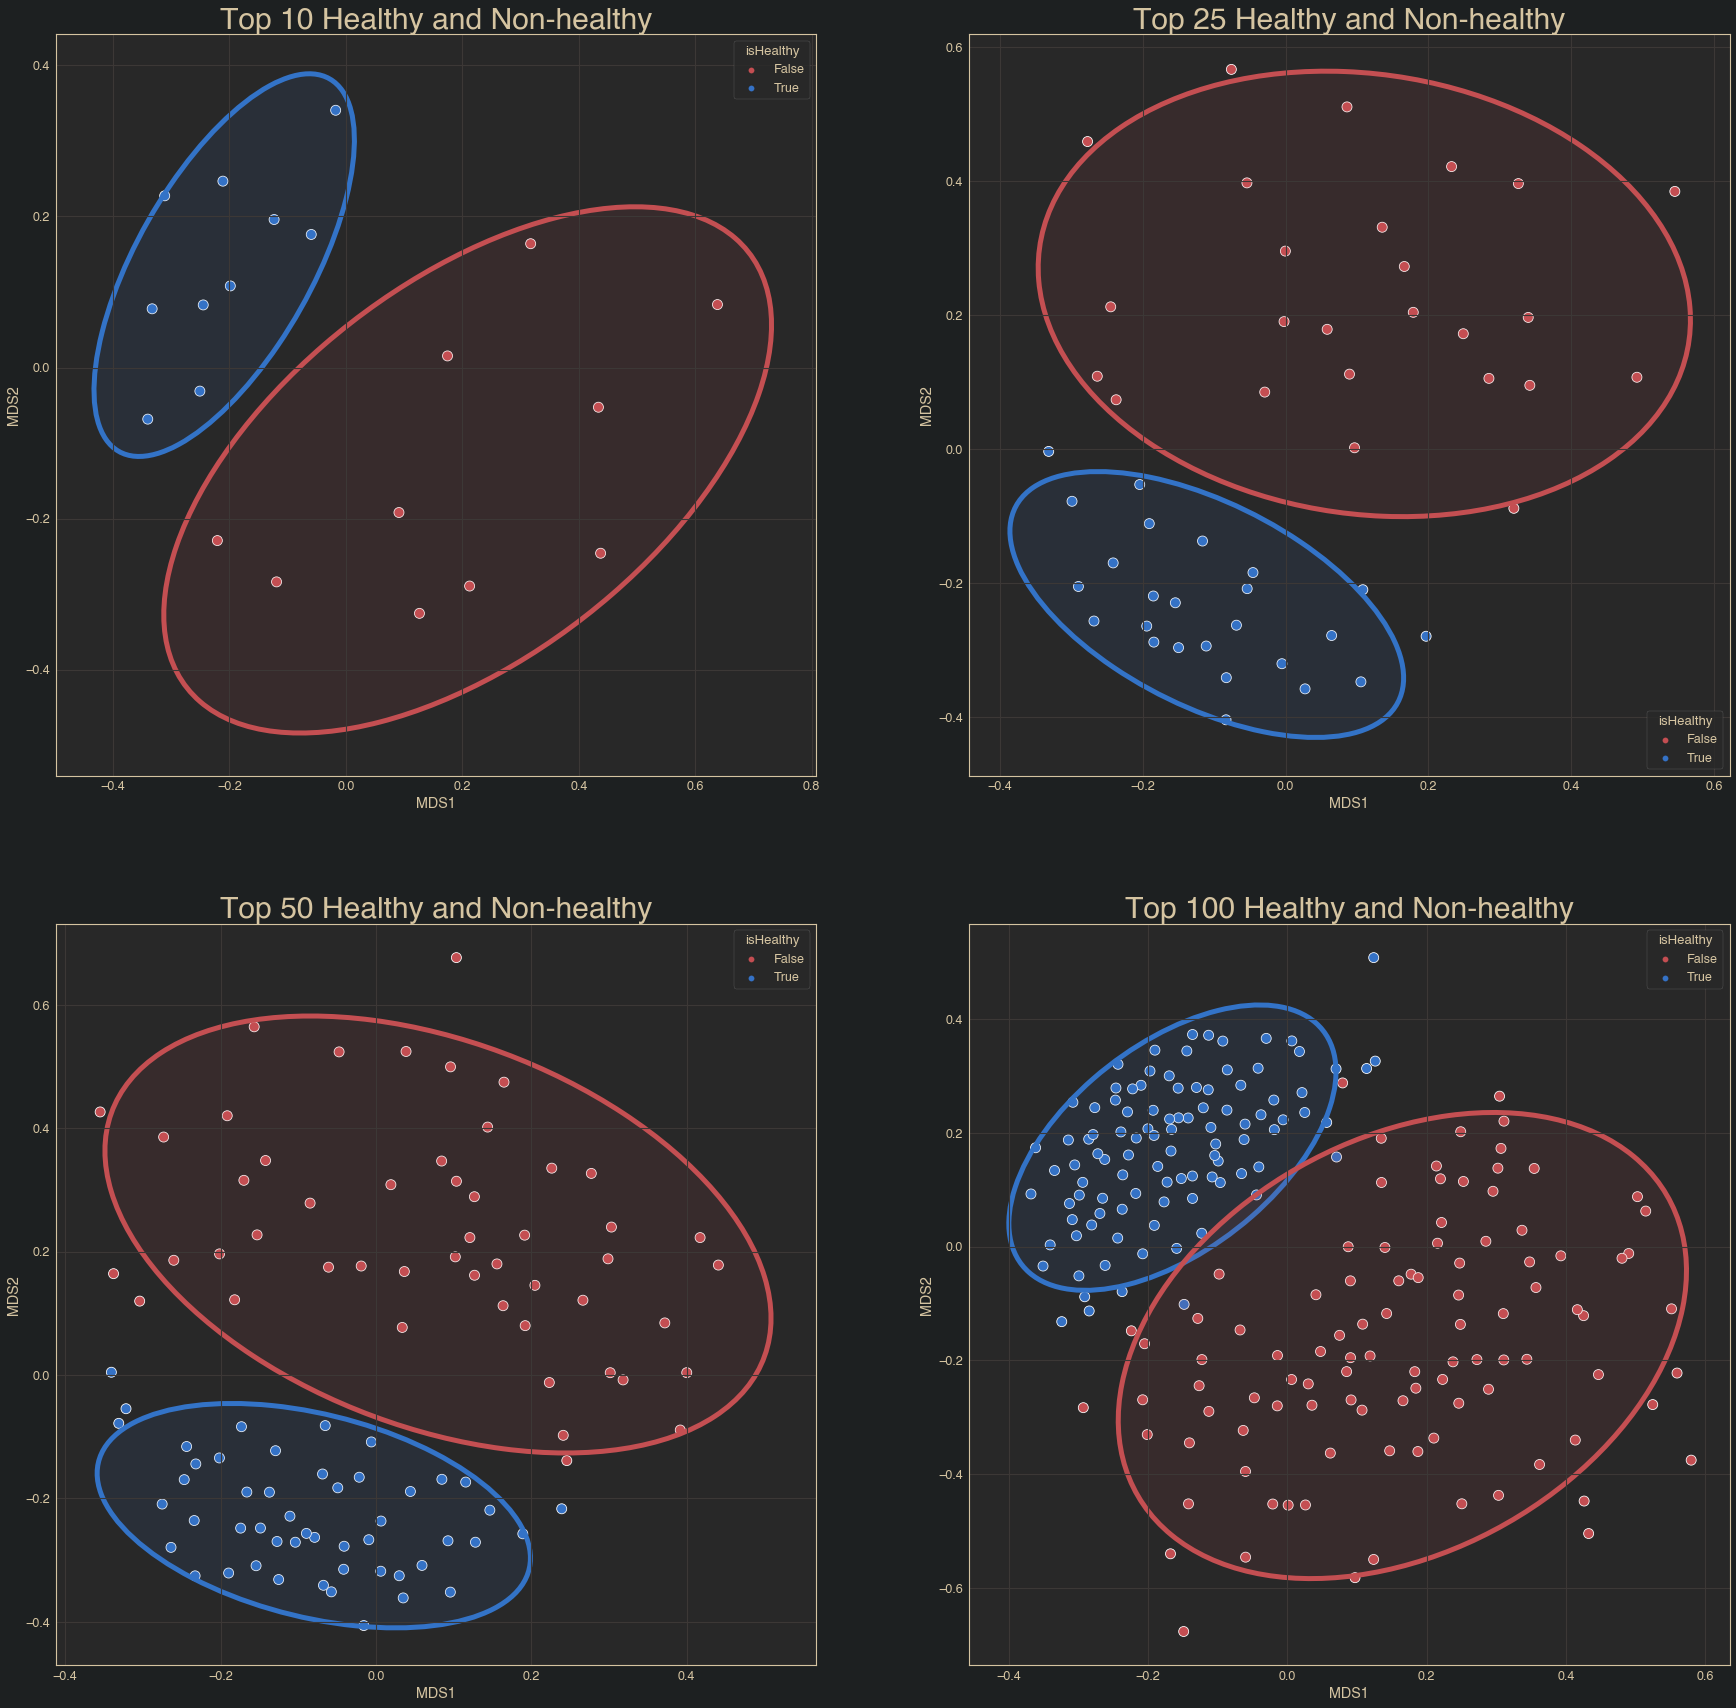

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

metric = 'braycurtis'

fig, axes = plt.subplots(2, 2, figsize=(30, 30))
axes = axes.flatten()

for idx, num_top in enumerate([10, 25, 50, 100]):
    ax = axes[idx]
    transformed = plot_top_values(X, y, gmhi_values, num_top, metric)
    sns.scatterplot(ax=ax, data=transformed, x="MDS1", y="MDS2", 
                    hue="isHealthy", palette=['r', 'b'], s=100)

    # create confidence ellipse for healthy and unhealthy
    healthies = transformed[transformed['isHealthy']]
    unhealthies = transformed[~transformed['isHealthy']]
    confidence_ellipse(healthies['MDS1'], healthies['MDS2'], ax, n_std=2.0, 
                       edgecolor=(0.2, 0.45, 0.78, 1), linewidth=5, facecolor=(0.2, 0.45, 0.78, 0.1))
    confidence_ellipse(unhealthies['MDS1'], unhealthies['MDS2'], ax, n_std=2.0, 
                       edgecolor=(0.77, 0.31, 0.32, 1), linewidth=5, facecolor=(0.77, 0.31, 0.32, 0.1))

    ax.set_title('Top ' + str(num_top) + " Healthy and Non-healthy", fontsize=30)
    plt.savefig(config.OUTPUT_DIR + "MDS.png")